### Read the station data from GHCN archive ###

Data obtained from http://www.ncdc.noaa.gov/cdo-web/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Data/598134.csv")

In [54]:
df.keys()

Index([u'STATION', u'STATION_NAME', u'ELEVATION', u'LATITUDE', u'LONGITUDE',
       u'DATE', u'PRCP', u'Measurement Flag', u'Quality Flag', u'Source Flag',
       u'Time of Observation', u'TMAX', u'Measurement Flag.1',
       u'Quality Flag.1', u'Source Flag.1', u'Time of Observation.1', u'TMIN',
       u'Measurement Flag.2', u'Quality Flag.2', u'Source Flag.2',
       u'Time of Observation.2'],
      dtype='object')

In [55]:
df.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,PRCP,Measurement Flag,Quality Flag,Source Flag,...,TMAX,Measurement Flag.1,Quality Flag.1,Source Flag.1,Time of Observation.1,TMIN,Measurement Flag.2,Quality Flag.2,Source Flag.2,Time of Observation.2
0,GHCND:KE000063661,KITALE KE,1875,1.016,35,20000101,0,,,I,...,286,,,I,9999,99,,,I,9999
1,GHCND:KE000063661,KITALE KE,1875,1.016,35,20000102,-9999,,,,...,280,,,I,9999,109,,,I,9999
2,GHCND:KE000063661,KITALE KE,1875,1.016,35,20000103,-9999,,,,...,280,,,I,9999,106,,,I,9999
3,GHCND:KE000063661,KITALE KE,1875,1.016,35,20000104,-9999,,,,...,-9999,,,,9999,98,,,I,9999
4,GHCND:KE000063661,KITALE KE,1875,1.016,35,20000105,0,,,I,...,288,,,I,9999,85,,,I,9999


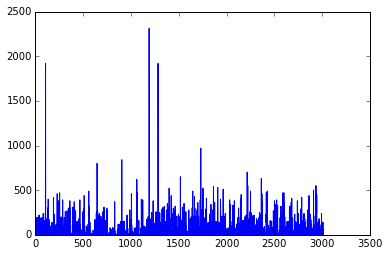

In [7]:
# Exaple of how to mask data and quick look
mask = df.PRCP != -9999
plt.plot(df.PRCP[mask])
plt.show()

In [8]:
# How to extract the head of the data
df.DATE.head()

0    20000101
1    20000102
2    20000103
3    20000104
4    20000105
Name: DATE, dtype: int64

In [16]:
print(df.DATE[0])
print(type(df.DATE[0]))
df.DATE[0]

20000101
<type 'numpy.int64'>


20000101

In [36]:
def get_date(date_number):
    """
    Turn the int64 value from the DATE of GHCN into a pd.datetime
    """
    dstring = str(date_number)
    return pd.datetime(int(dstring[0:4]),int(dstring[4:6]),int(dstring[6:8]))

In [37]:
get_date(df.DATE[0])

datetime.datetime(2000, 1, 1, 0, 0)

In [38]:
# How to create a pd.datetime index to subscript the data (IMPORTANT)
dates = [get_date(day) for day in df.DATE]

In [49]:
# How to put the index and the data of interest together into one frame
mydata = pd.DataFrame(data=df.PRCP.values,index=dates,columns=[df.STATION[0][6:]])

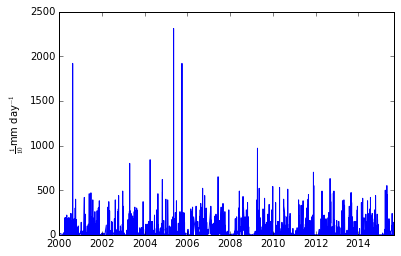

In [63]:
mask = mydata.KE000063661 != -9999
plt.plot(mydata.index[mask],mydata.KE000063661[mask])
plt.ylabel(r"$\frac{1}{10}$mm day$^{-1}$")

In [57]:
pd.concat([mydata.KE000063661,mydata.KE000063661],axis=1)

#mydata

,KE000063661,KE000063661
2000-01-01,0,0
2000-01-02,-9999,-9999
2000-01-03,-9999,-9999
2000-01-04,-9999,-9999
2000-01-05,0,0
2000-01-06,-9999,-9999
2000-01-08,-9999,-9999
2000-01-09,-9999,-9999
2000-01-10,-9999,-9999
2000-01-11,-9999,-9999
